In [31]:
pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 405 kB/s 
     |████████████████████████████████| 11.2 MB 60.6 MB/s 
     |████████████████████████████████| 61 kB 8.3 MB/s 
     |████████████████████████████████| 15.7 MB 18.3 MB/s 
     |████████████████████████████████| 9.9 MB 68.5 MB/s 
     |████████████████████████████████| 944 kB 62.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
import torch
import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용되는 패키지
# import torchvision.models as models # 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn.functional as F

from d2l import torch as d2l
import matplotlib.pyplot as plt
import numpy as np
import string
from sklearn.metrics import accuracy_score

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [24]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.EMNIST(root="../data",train=True, split="letters", transform=trans, download=True)
mnist_test = torchvision.datasets.EMNIST(root="../data", train=False, split="letters", transform=trans, download=True)

In [25]:
len(mnist_train), len(mnist_test)

(124800, 20800)

In [26]:
mnist_train[0][0].size()

torch.Size([1, 28, 28])

In [27]:
def get_labels(labels):
  text_labels = ["N/A"] + list(string.ascii_lowercase)
  return [text_labels[int(i)] for i in labels]

In [8]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  """Plot a list of images."""
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    if torch.is_tensor(img):
      # Tensor Image
      ax.imshow(img.numpy())
    else:
      # PIL Image
      ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles:
      ax.set_title(titles[i])
  return axes

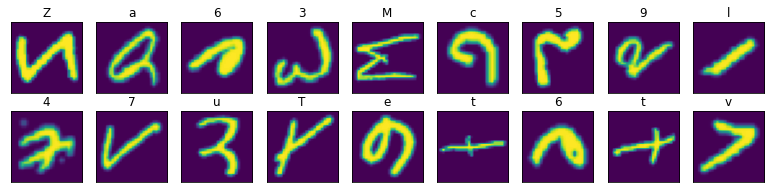

In [9]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_labels(y));

In [28]:
text_labels = ["N/A"] + list(string.ascii_lowercase)
len(text_labels) # output의 크기

27

In [38]:
class emnistMLP(nn.Module):

  def __init__(self):
    super(emnistMLP, self).__init__()

    self.layer1 = nn.Sequential(
      nn.Flatten(), # hidden layer가 linear 이므로 flatten 과정을 넣어준다.
      nn.Linear(784,512, bias=True), # input_layer = 1*28*28, hidden_layer1 = 512
      nn.ReLU(),
      nn.BatchNorm1d(512),
      nn.Dropout(0.2))

    self.layer2 = nn.Sequential(
        nn.Linear(512,256, bias=True),
        nn.ReLU(),
        nn.BatchNorm1d(256)        )

    self.layer3 = nn.Sequential(
        nn.Linear(256,128, bias=True),
        nn.ReLU(),
        nn.BatchNorm1d(128))

    self.layer4 = nn.Sequential(
        nn.Linear(128,27, bias=True),
        nn.Softmax())

  def forward(self, input_data):
    output = self.layer1(input_data)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [39]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.05)
        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [40]:
x_sum = 0
for x_train, y_train in data.DataLoader(mnist_train, batch_size=24*24):
  x_sum+=1
print(x_sum)

217


In [41]:
from tqdm import tqdm

# underfitting


In [44]:
model = emnistMLP()
model.apply(init_weights)
losses = []

optimizer = optim.Adam(model.parameters(), lr= 0.00001)
loss_fn  = nn.CrossEntropyLoss().to(device)

for epoch in range(10):
  for x_train, y_train in tqdm(data.DataLoader(mnist_train, batch_size=24*24, shuffle=True, num_workers=4)):
    optimizer.zero_grad()
    hypothesis = model(x_train)

    # 비용 함수
    cost = loss_fn(hypothesis, y_train)
    cost.backward()
    optimizer.step()
    losses.append(cost.item())

  print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/217 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 217/217 [00:15<00:00, 13.96it/s]

0 3.1764068603515625


100%|██████████| 217/217 [00:15<00:00, 14.19it/s]


1 3.0465993881225586


100%|██████████| 217/217 [00:15<00:00, 14.19it/s]


2 2.9091291427612305


100%|██████████| 217/217 [00:15<00:00, 13.69it/s]


3 2.8866045475006104


100%|██████████| 217/217 [00:15<00:00, 14.24it/s]


4 2.838299512863159


100%|██████████| 217/217 [00:15<00:00, 13.94it/s]


5 2.799772024154663


100%|██████████| 217/217 [00:19<00:00, 11.08it/s]


6 2.8011624813079834


100%|██████████| 217/217 [00:15<00:00, 14.06it/s]


7 2.8118467330932617


100%|██████████| 217/217 [00:15<00:00, 14.02it/s]


8 2.7569353580474854


100%|██████████| 217/217 [00:15<00:00, 14.27it/s]

9 2.70139217376709


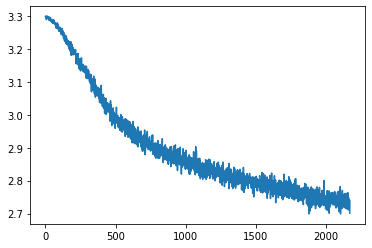

In [45]:
plt.plot(losses)
plt.show()

In [76]:
model = emnistMLP()
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr= 0.0001)
loss_fn  = nn.CrossEntropyLoss().to(device)

losses = []

for epoch in range(10):
  for x_train, y_train in tqdm(data.DataLoader(mnist_train, batch_size=24*24, shuffle=True, num_workers=4)):
    optimizer.zero_grad()
    hypothesis = model(x_train)

    # 비용 함수
    cost = loss_fn(hypothesis, y_train)
    cost.backward()
    optimizer.step()
    losses.append(cost.item())

  print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/217 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 217/217 [00:17<00:00, 12.25it/s]

0 2.72688889503479


100%|██████████| 217/217 [00:17<00:00, 12.68it/s]


1 2.632518768310547


100%|██████████| 217/217 [00:15<00:00, 13.65it/s]


2 2.5769460201263428


100%|██████████| 217/217 [00:15<00:00, 13.97it/s]


3 2.547877073287964


100%|██████████| 217/217 [00:15<00:00, 14.05it/s]


4 2.5286672115325928


100%|██████████| 217/217 [00:15<00:00, 13.77it/s]


5 2.552490472793579


100%|██████████| 217/217 [00:19<00:00, 11.38it/s]


6 2.5392377376556396


100%|██████████| 217/217 [00:18<00:00, 11.52it/s]


7 2.5085856914520264


100%|██████████| 217/217 [00:16<00:00, 12.83it/s]


8 2.5068013668060303


100%|██████████| 217/217 [00:17<00:00, 12.40it/s]

9 2.4828484058380127


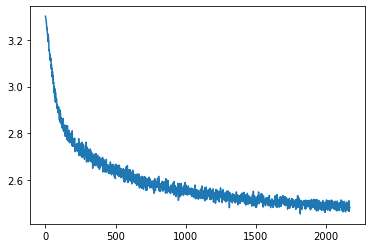

In [79]:
plt.plot(losses)
plt.show()

In [80]:
x_test, y_test = next(iter(data.DataLoader(mnist_train, batch_size=18)))

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [2.4806731e-03 3.3397984e-02 1.4177606e-02 5.6058454e-04 2.8179373e-04
 1.4816837e-03 3.4264413e-05 2.2084510e-03 5.9353501e-02 3.1649837e-05
 9.4399067e-05 1.2832911e-01 1.4201222e-05 4.5566719e-02 5.3272396e-01
 5.5997539e-04 2.2389796e-02 2.8103235e-04 4.4000294e-02 1.7382750e-05
 2.0926639e-03 4.8669628e-03 6.3619582e-04 5.8868766e-02 1.8844616e-02
 2.5317874e-02 1.3878279e-03]
argmax를 한 후의 output은 14
accuracy는 0.7222222222222222


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


# optimal

In [81]:
model = emnistMLP()
model.apply(init_weights)
losses = []

optimizer = optim.Adam(model.parameters(), lr = 0.0005)
loss_fn  = nn.CrossEntropyLoss().to(device)

for epoch in range(10):
  for x_train, y_train in tqdm(data.DataLoader(mnist_train, batch_size=24*24, shuffle=True, num_workers=4)):
    optimizer.zero_grad()
    hypothesis = model(x_train)

    # 비용 함수
    cost = loss_fn(hypothesis, y_train)
    cost.backward()
    optimizer.step()
    losses.append(cost.item())

  print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/217 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 217/217 [00:17<00:00, 12.06it/s]

0 2.5667335987091064


100%|██████████| 217/217 [00:15<00:00, 13.75it/s]


1 2.540548801422119


100%|██████████| 217/217 [00:15<00:00, 14.00it/s]


2 2.455915689468384


100%|██████████| 217/217 [00:15<00:00, 13.85it/s]


3 2.4564855098724365


100%|██████████| 217/217 [00:15<00:00, 13.89it/s]


4 2.4335596561431885


100%|██████████| 217/217 [00:15<00:00, 13.93it/s]


5 2.471681833267212


100%|██████████| 217/217 [00:15<00:00, 14.02it/s]


6 2.4534435272216797


100%|██████████| 217/217 [00:16<00:00, 13.07it/s]


7 2.439530372619629


100%|██████████| 217/217 [00:15<00:00, 13.97it/s]


8 2.4487507343292236


100%|██████████| 217/217 [00:15<00:00, 14.01it/s]

9 2.4342539310455322


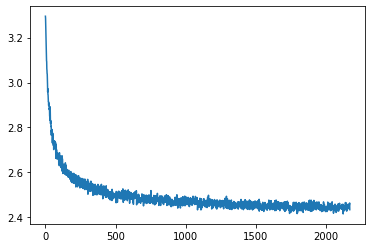

In [84]:
plt.plot(losses)
plt.show()

In [83]:
x_test, y_test = next(iter(data.DataLoader(mnist_train, batch_size=18)))

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}') # lr을 2배 증가시켰고, accuarcy도 증가하였다.

model의 output은 :  [3.1194256e-06 3.0281015e-05 6.3364446e-02 7.6418026e-08 1.0389387e-08
 4.9989603e-07 7.2050610e-09 4.2702194e-08 6.3409053e-02 2.8508446e-10
 1.8737511e-08 1.7233120e-04 8.5348857e-09 1.0058949e-03 3.3840821e-05
 5.5270368e-07 4.5375280e-05 4.3296218e-08 6.8352972e-05 6.7771833e-09
 1.3433382e-06 1.1192575e-06 7.0989373e-08 8.7173116e-01 1.7487738e-09
 1.1483248e-04 1.7544202e-05]
argmax를 한 후의 output은 23
accuracy는 0.8333333333333334


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


# overfitting

In [73]:
model = emnistMLP()
model.apply(init_weights)
losses = []

optimizer = optim.Adam(model.parameters(), lr =  0.001)
loss_fn  = nn.CrossEntropyLoss().to(device)

for epoch in range(10):
  for x_train, y_train in tqdm(data.DataLoader(mnist_train, batch_size=24*24, shuffle=True, num_workers=4)):
    optimizer.zero_grad()
    hypothesis = model(x_train)

    # 비용 함수
    cost = loss_fn(hypothesis, y_train)
    cost.backward()
    optimizer.step()
    losses.append(cost.item())

  print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/217 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 217/217 [00:17<00:00, 12.53it/s]

0 2.5433032512664795


100%|██████████| 217/217 [00:15<00:00, 13.71it/s]


1 2.521801233291626


100%|██████████| 217/217 [00:18<00:00, 11.84it/s]


2 2.482043504714966


100%|██████████| 217/217 [00:16<00:00, 12.87it/s]


3 2.455705404281616


100%|██████████| 217/217 [00:17<00:00, 12.46it/s]


4 2.449899435043335


100%|██████████| 217/217 [00:15<00:00, 13.76it/s]


5 2.471050500869751


100%|██████████| 217/217 [00:15<00:00, 14.06it/s]


6 2.434906005859375


100%|██████████| 217/217 [00:15<00:00, 14.21it/s]


7 2.443495750427246


100%|██████████| 217/217 [00:15<00:00, 13.91it/s]


8 2.448719024658203


100%|██████████| 217/217 [00:15<00:00, 13.56it/s]

9 2.4344913959503174


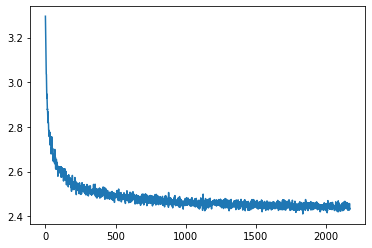

In [74]:
plt.plot(losses)
plt.show()

In [75]:
x_test, y_test = next(iter(data.DataLoader(mnist_train, batch_size=18)))

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}') # lr를 2배 증가시켰는데, accuracy는 오히려 낮아졌다. >> overfitting 되었다.

model의 output은 :  [1.3035979e-07 6.7736379e-05 1.2214744e-04 1.7081615e-07 1.7176204e-08
 2.2924656e-09 5.7236784e-09 8.5224514e-07 2.7378832e-05 3.2464811e-10
 1.6659610e-10 2.9312110e-07 1.6107037e-09 6.5153494e-05 1.1903620e-03
 4.0768362e-05 2.0705056e-05 2.7845319e-06 7.3142942e-06 4.4436263e-08
 1.2378818e-09 1.9904878e-08 9.3552984e-07 9.9845314e-01 2.2484083e-09
 3.0925392e-08 1.2537434e-08]
argmax를 한 후의 output은 23
accuracy는 0.7777777777777778


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


부록

In [62]:
data_path_train = '/content/drive/MyDrive/Colab Notebooks/Pytorch스터디/DATA/catanddog/train'
data_path_test = '/content/drive/MyDrive/Colab Notebooks/Pytorch스터디/DATA/catanddog/test'
batch_size=32

def dataloader_func(path, batch_size):
  transform = transforms.Compose([transforms.Resize([64,64]), # 합성곱층을 퇑과하기 위해 이미지 크기를 조정하는 전처리 과정이다.
                                transforms.RandomHorizontalFlip(), # 이미지를 랜덤하게 수평으로 뒤집는다.
                                transforms.ToTensor()]) # 이미지 데이터를 텐서로 변환
  dataset = torchvision.datasets.ImageFolder(data_path_train, transform=transform)
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           num_workers=8, # 하위 프로세스를 몇개 사용할지 설정한다.
                                           shuffle=True)
  return dataset, loader

train_dataset, train_loader = dataloader_func(data_path_train, batch_size)
test_dataset, test_loader = dataloader_func(data_path_test, batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [63]:
samples, labels = iter(train_loader).next()
print(len(train_dataset)) # dataset 길이 : 385
print(samples.shape) # dataset 모양 : resize완료 batchsize=64, depth=3, 64X64 형태로 Resize

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


385
torch.Size([32, 3, 64, 64])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


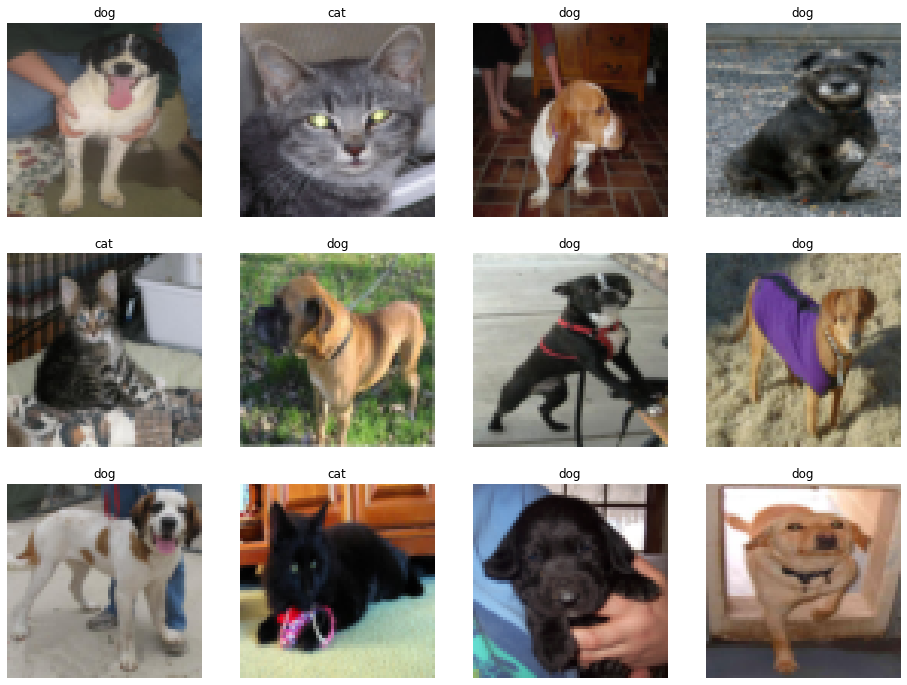

In [64]:
samples, labels = iter(train_loader).next()
classes = {0:'cat',1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(12):
  a = fig.add_subplot(3,4,i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [65]:
class CatNDogMLP(nn.Module):

  def __init__(self):
    super(CatNDogMLP, self).__init__()

    self.layer1 = nn.Sequential(
      nn.Flatten(), # hidden layer가 linear 이므로 flatten 과정을 넣어준다.
      nn.Linear(4096*3,1024, bias=True), # input_layer = 4096, hidden_layer1 = 1024
      nn.ReLU(),
      #nn.BatchNorm1d(1024),
      nn.Dropout(0.2))

    self.layer2 = nn.Sequential(
        nn.Linear(1024,256, bias=True),
        nn.ReLU(),
        #nn.BatchNorm1d(256),
        nn.Dropout(0.2))

    self.layer3 = nn.Sequential(
        nn.Linear(256,64, bias=True),
        nn.ReLU(),
        #nn.BatchNorm1d(64),
        nn.Dropout(0.2))

    self.layer4 = nn.Sequential(
        nn.Linear(64,2, bias=True),
        nn.Softmax())

  def forward(self, input_data):
    output = self.layer1(input_data)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [66]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.05)
        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [67]:
x_sum = 0
for x_train, y_train in train_loader:
  x_sum+=len(x_train)
  print(x_sum)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


32
64
96
128
160
192
224
256
288
320
352
384
385


In [68]:
model = CatNDogMLP()
model.apply(init_weights)
losses = []

optimizer = optim.Adam(model.parameters(), lr= 0.00001)
loss_fn  = nn.CrossEntropyLoss().to(device)

for epoch in range(100):
  for x_train, y_train in train_loader:
    optimizer.zero_grad()
    hypothesis = model(x_train)

    # 비용 함수
    cost = loss_fn(hypothesis, y_train)
    cost.backward()
    optimizer.step()
    losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 0.8928618431091309
10 0.4246646463871002
20 0.46041399240493774


KeyboardInterrupt: ignored

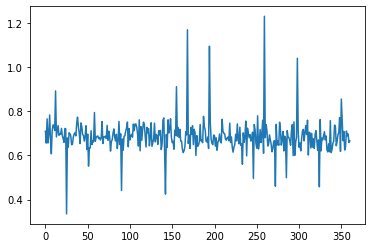

In [69]:
plt.plot(losses) # 이유를 아무리 찾아봐도 왜 진동하는지 모르겠다.
plt.show()